Project 1

import package

In [1]:
import time
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import jax.numpy as jnp
from transforms3d import quaternions
from transforms3d import euler
import pickle
import jax
from jax import vmap
from jax import grad

part 1: orientation tracking

import data

In [2]:
def tic():
  return time.time()
def toc(tstart, nm=""):
  print('%s took: %s sec.\n' % (nm,(time.time() - tstart)))

def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    if sys.version_info[0] < 3:
      d = pickle.load(f)
    else:
      d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

dataset="1"
cfile = "../data/cam/cam" + dataset + ".p"
ifile = "../data/imu/imuRaw" + dataset + ".p"
vfile = "../data/vicon/viconRot" + dataset + ".p"

ts = tic()

(5645, 7)
(5644,)


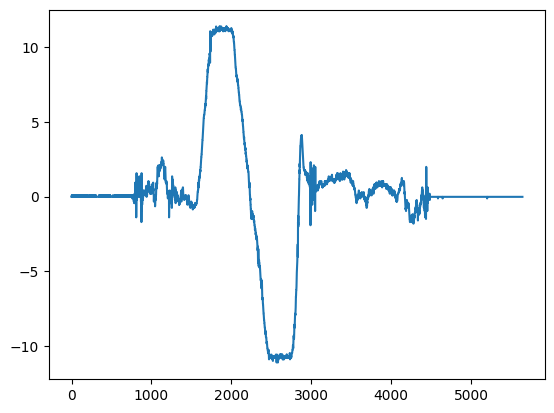

In [3]:
imud = read_data(ifile)
vicd = read_data(vfile)
# toc(ts,"Data import")

imud = np.transpose(imud)
imud[:, 1:4] = imud[:, 1:4] * 9.81
accBias = np.mean(imud[:100, 1:4], axis=0) - np.array([0, 0, 9.81]) / (3300 / 1023 / 300)
gyroBias = np.mean(imud[:100, 4:7], axis=0)

imud[:, 1:4] =  (imud[:, 1:4] - accBias) * (3300 / 1023 / 300)
imud[:, 4:7] =  (imud[:, 4:7] - gyroBias) * (3300 / 1023 * np.pi / 180 / 3.33)

plt.plot(imud[:, 1])

times = np.zeros(imud.shape[0] - 1)
for i in range(imud.shape[0]- 1):
    times[i] = imud[i+1, 0] - imud[i, 0]

print(imud.shape)
print(times.shape)

kinematics model

In [4]:
kinematicsModel = np.zeros((imud.shape[0], 4))
kinematicsModel[0,:] = [1, 0, 0, 0]
rollPitchYawEstimate = np.zeros((imud.shape[0], 3))
for i in range(kinematicsModel.shape[0] - 1):
    kinematicsModel[i+1,:] = quaternions.qmult(kinematicsModel[i, :], quaternions.qexp([0, times[i] * imud[i, 4], times[i] * imud[i, 5], times[i] * imud[i, 6] / 2]))
    kinematicsModel[i+1,:] = kinematicsModel[i+1,:] / quaternions.qnorm(kinematicsModel[i+1,:])    
    rollPitchYawEstimate[i, :] = euler.quat2euler(kinematicsModel[i, :])
rollPitchYawEstimate = rollPitchYawEstimate * 180 / np.pi


gradient descent

In [23]:
# Checking for learning rate
# error = np.zeros((4, 200))

In [5]:
jax.config.update("jax_debug_nans", True)
def qmult(q1, q2):
    q = jnp.array([q1[0] * q2[0] - jnp.dot(q1[1:], q2[1:]), 0.0, 0.0, 0.0])
    q = q.at[1:].set(q1[0] * q2[1:] + q2[0] * q1[1:] + jnp.linalg.cross(q1[1:], q2[1:]))
    return q

# Real part of q should be log(q), but suppose q1 norm should be equal to 1, I set it directly to 0.
# When I use jnp.log, gradient would get nan in some rows.
def qlog(q1):
    q_norm = jnp.linalg.norm(q1) + 1e-10
    qv_norm = jnp.linalg.norm(q1[1:])+ 1e-10
    q = jnp.array([0, 0, 0, 0])
    q = q.at[1:].set(q1[1:] / qv_norm * jnp.arccos(q1[0] / q_norm))
    return jnp.where(q_norm > 1e-6, q, jnp.array([1.0, 0.0, 0.0, 0.0]))

def qexp(q1):
    qv_norm = jnp.linalg.norm(q1[1:]) + 1e-10
    q = jnp.array([jnp.cos(qv_norm), 0.0, 0.0, 0.0])
    q = q.at[1:].set(q1[1:] / qv_norm * jnp.sin(qv_norm))
    q = q * jnp.exp(q1[0])
    return jnp.where(qv_norm > 1e-6, q, jnp.array([1.0, 0.0, 0.0, 0.0]))

def qinverse(q1):
    q_norm = jnp.linalg.norm(q1) + 1e-10
    q = jnp.array([q1[0], -q1[1], -q1[2], -q1[3]]) / (q_norm ** 2)
    return jnp.where(q_norm > 1e-6, q, jnp.array([1.0, 0.0, 0.0, 0.0]))

def calMotionError(kinematicsModel, imud, times):
    def step(q1, q2, imud, times):
        return jnp.linalg.norm(2 * qlog(qmult(qinverse(q2), qmult(q1, qexp(jnp.array([0, times * imud[4], times * imud[5], times * imud[6]]) / 2))))) ** 2
    return vmap(step)(kinematicsModel[:-1, :], kinematicsModel[1:, :], imud[:-1, :], times)

def calObserveError(kinematicsModel, imud):
    def step(q, imud):
        return jnp.linalg.norm(jnp.array([0, imud[1], imud[2], imud[3]]) - qmult(qmult(qinverse(q), jnp.array([0.0, 0.0, 0.0, 9.81])), q)) ** 2
    return vmap(step)(kinematicsModel[1:, :], imud[1:, :])


def costFunc(kinematicsModel, imud, times):
    cost = 0
    motionError = calMotionError(kinematicsModel, imud, times)
    observeError = calObserveError(kinematicsModel, imud)
    cost = 0.5 * (jnp.sum(motionError) + jnp.sum(observeError))
    print(cost)
    return cost

def normKinematicsModel(kinematicsModel):
    def qnormalize(q):
        return q / jnp.linalg.norm(q)
    return vmap(qnormalize)(kinematicsModel)

learningRate = [1e-3, 5e-4, 1e-4, 5e-5]
for iter in range(200):
    kinematicsModel = jnp.array(kinematicsModel)
    imu = jnp.array(imud)
    timesjnp = jnp.array(times)
    # error[3, iter] = costFunc(kinematicsModel, imud, times)
    gradient = jnp.array(grad(costFunc)(kinematicsModel, imud, times))
    kinematicsModel = np.array(kinematicsModel)
    gradient = np.array(gradient) * learningRate[0]
    kinematicsModel = normKinematicsModel(kinematicsModel - gradient)


/usr/local/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Traced<ShapedArray(float32[])>with<JVPTrace> with
  primal = Array(213171.31, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x15dfcc280>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace>, Traced<ShapedArray(float32[]):JaxprTrace>), out_tracer_refs=[<weakref at 0x15dfc5c10; to 'JaxprTracer' at 0x15dfc5a80>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul b a in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'multiply', 'keep_unused': False, 'inline': True, 'compiler_options_kvs': ()}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x15dfa79d0>, ctx=JaxprEqnContext(compute_type=None, threefry_part

/usr/local/lib/python3.11/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Traced<ShapedArray(float32[])>with<JVPTrace> with
  primal = Array(123686.59, dtype=float32)
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x15dfcc3c0>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace>, Traced<ShapedArray(float32[]):JaxprTrace>), out_tracer_refs=[<weakref at 0x15e0f6b60; to 'JaxprTracer' at 0x15e0f6a70>], out_avals=[ShapedArray(float32[])], primitive=pjit, params={'jaxpr': { lambda ; a:f32[] b:f32[]. let c:f32[] = mul b a in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'in_layouts': (None, None), 'out_layouts': (None,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'multiply', 'keep_unused': False, 'inline': True, 'compiler_options_kvs': ()}, effects=set(), source_info=<jax._src.source_info_util.SourceInfo object at 0x15df25000>, ctx=JaxprEqnContext(compute_type=None, threefry_part

Text(0.5, 0, 'iteration')

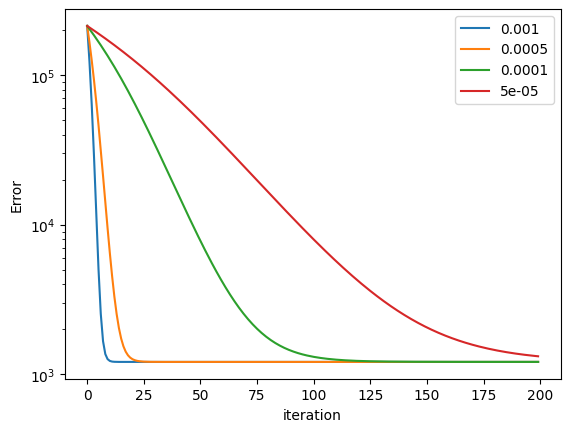

In [40]:
# plot learning rate
# plt.plot(error[0,:])
# plt.plot(error[1,:])
# plt.plot(error[2,:])
# plt.plot(error[3,:])
# plt.yscale('log')
# plt.legend([1e-3, 5e-4, 1e-4, 5e-5])
# plt.ylabel("Error")
# plt.xlabel("iteration")

ObserveModel (for check)

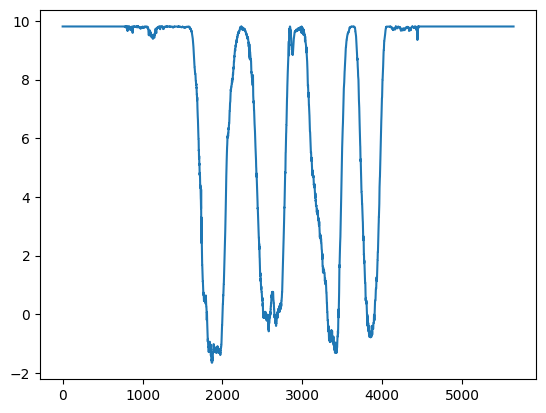

In [6]:
def ObserveModel(kinematicsModel):
    def step(q):
        return qmult(qmult(qinverse(q), jnp.array([0.0, 0.0, 0.0, 9.81])),q)
    return vmap(step)(kinematicsModel[1:, :])

test = ObserveModel(kinematicsModel)
# print(test)
plt.figure()
plt.plot(test[:, 3])

vicon data

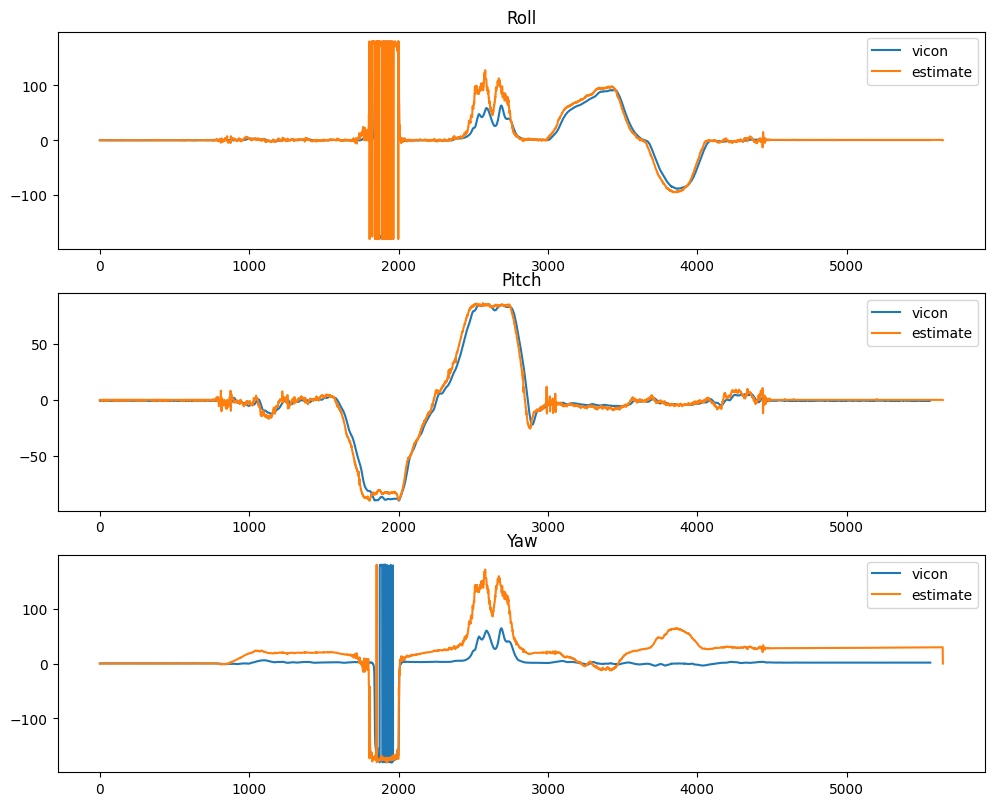

In [7]:
# def calAngle(rot):
#     # https://stackoverflow.com/questions/15022630/how-to-calculate-the-angle-from-rotation-matrix
#     # wiki: https://en.wikipedia.org/wiki/Rotation_matrix
#     row = np.arctan2(rot[2, 1], rot[2, 2]) * 180 / np.pi
#     pitch = np.arctan2(-rot[2, 0], np.sqrt(rot[2, 1] ** 2 + rot[2, 2] ** 2)) * 180 / np.pi
#     yaw = np.arctan2(rot[1, 0], rot[0, 0]) * 180 / np.pi
#     return row, pitch, yaw


rotation = vicd['rots']
rollPitchYaw = np.zeros((rotation.shape[2], 3))
for i in range(rotation.shape[2]):
    rollPitchYaw[i, :] = euler.mat2euler(rotation[:, :, i])
rollPitchYaw = rollPitchYaw * 180 / np.pi

for i in range(kinematicsModel.shape[0] - 1):
    rollPitchYawEstimate[i, :] = euler.quat2euler(kinematicsModel[i, :])
rollPitchYawEstimate = rollPitchYawEstimate * 180 / np.pi


fig, axs = plt.subplots(3, 1, figsize=(10, 8))
fig.tight_layout()
axs[0].plot(rollPitchYaw[:, 0])
axs[0].plot(rollPitchYawEstimate[:, 0])
axs[0].set_title("Roll")
# axs[0].legend(["estimate"])
axs[0].legend(["vicon", "estimate"])
axs[1].plot(rollPitchYaw[:, 1])
axs[1].plot(rollPitchYawEstimate[:, 1])
axs[1].set_title("Pitch")
# axs[1].legend(["estimate"])
axs[1].legend(["vicon", "estimate"])
axs[2].plot(rollPitchYaw[:, 2])
axs[2].plot(rollPitchYawEstimate[:, 2])
axs[2].set_title("Yaw")
# axs[2].legend(["estimate"])
axs[2].legend(["vicon", "estimate"])
plt.show()

panorama

In [68]:
camd = read_data(cfile)
print(type(camd))
print(camd.keys())
# camd --> (height, width, RGB, frame)
print(camd["cam"].shape) 
# print(camd["cam"][:, :, 0, 0])
plt.figure()
plt.imshow(camd["cam"][:, :, :, 500])


<class 'dict'>
dict_keys(['cam', 'ts'])
(240, 320, 3, 1685)


calculate spacing ratio

In [70]:
startTime = 0
spacingRatio = max(int((camd["ts"][0][1] - camd["ts"][0][0]) / (imud[1, 0] - imud[0, 0])), 1)
for i in range(imud.shape[0]):
    if imud[i, 0] > camd["ts"][0][0]:
        startTime = i
        break
print(spacingRatio)
print(startTime)

3
149


In [71]:
def cart2sph(q):
    # return longitude, latitude
    return [jnp.arctan2(q[1], q[0]) * 180 / jnp.pi, jnp.arccos(q[2] / jnp.array(jnp.linalg.norm(q))) * 180 / jnp.pi]

def pictureRotate(q, coordinates):
    def pixelRotate(q, coordinate):
        cartesian = qmult(qmult(q, jnp.array([0, coordinate[0], coordinate[1], coordinate[2]])), qinverse(q))[1:]
        # cartesian = qmult(qmult(q, jnp.array([0, 1, 0, 0])), qinverse(q))[1:]
        return cart2sph(cartesian)
    q = q * jnp.ones((coordinates.shape[0], 1))
    # print(q.shape)
    # print(coordinates.shape)
    return vmap(pixelRotate)(q, coordinates)

# unit(degree / pixel)
latitudeUnit = 45 / 240  
longitudeUnit = 60 / 320
coordinates = np.zeros((240 * 320, 3))
for row in range(240):
    for col in range(320):
        coordinates[row * 320 + col][0] = np.cos(latitudeUnit * (row - 120) * np.pi / 180) * np.cos(longitudeUnit * (col - 160) * np.pi / 180)
        coordinates[row * 320 + col][1] = np.cos(latitudeUnit * (row - 120) * np.pi / 180) * np.sin(longitudeUnit * (col - 160) * np.pi / 180)
        coordinates[row * 320 + col][2] = np.sin(latitudeUnit * (row - 120) * np.pi / 180)


paronama with estimate trajectory

In [72]:

sphericalRGB = np.zeros((180, 360, 3))
frameNum = camd["ts"][0].shape[0]
camOrientation = kinematicsModel[startTime::spacingRatio]
for frame in range(frameNum - 1):
    pic = camd["cam"][:, :, :, frame - startTime]
    # print(qmult(qmult(kinematicsModel[frame, :], jnp.array([0, 1, 0, 0])), qinverse(kinematicsModel[frame, :]))[1:])
    longitudes, latitudes = pictureRotate(camOrientation[frame, :], coordinates)
    longitudes = np.array(longitudes)
    latitudes = np.array(latitudes)
    # print(longitudes[120 * 160], latitudes[120 * 160])
    for row in range(240):
        for col in range(320):
            latitude = int(latitudes[row * 320 + col])
            longitude = int(longitudes[row * 320 + col])
            # print(latitude, longitude)
            if latitude >= 0 and latitude < 180 and longitude >= -180 and longitude < 180:
                sphericalRGB[179 - latitude, longitude + 180, :] = pic[row, col, :]



paronama with vicon data

In [78]:
groundTruth = np.zeros((rollPitchYaw.shape[0], 4))
for i in range(groundTruth.shape[0]):
    groundTruth[i, :] = quaternions.mat2quat(rotation[:, :, i])

viconRGB = np.zeros((180, 360, 3))
frameNum = camd["ts"][0].shape[0]
camGroundTruth = groundTruth[startTime::spacingRatio]
for frame in range(frameNum - 1):
    pic = camd["cam"][:, :, :, frame - startTime]
    # print(qmult(qmult(kinematicsModel[frame, :], jnp.array([0, 1, 0, 0])), qinverse(kinematicsModel[frame, :]))[1:])
    longitudes, latitudes = pictureRotate(camGroundTruth[frame, :], coordinates)
    longitudes = np.array(longitudes)
    latitudes = np.array(latitudes)
    # print(longitudes[120 * 160], latitudes[120 * 160])
    for row in range(240):
        for col in range(320):
            latitude = int(latitudes[row * 320 + col])
            longitude = int(longitudes[row * 320 + col])
            # print(latitude, longitude)
            if latitude >= 0 and latitude < 180 and longitude >= -180 and longitude < 180:
                viconRGB[179 - latitude, longitude + 180, :] = pic[row, col, :]

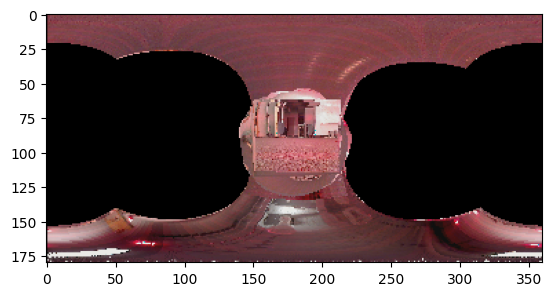

In [79]:
plt.imshow(viconRGB.astype('uint8'))